In [1]:
# !pip install --upgrade wandb
# !wandb login 3da7a23df9fd940d985adf808de2b09ceb85f15b

# import wandb
# wandb.init(project="global-wheat-detection")

In [2]:
%%capture
!pip install cython
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .

In [3]:
import os
import ast
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

import torch
from PIL import Image
from tqdm.auto import tqdm

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from matplotlib import pyplot as plt
import matplotlib.patches as patches

import utils
from engine import train_one_epoch, evaluate

In [4]:
# Constants
TEST_DIR = '/kaggle/input/global-wheat-detection/test'
BASE_DIR = '/kaggle/input/gwdaugmented/train'

In [5]:
train_df = pd.read_csv(os.path.join('/kaggle/input/gwdaugmented/', 'train.csv'))
train_df

image_id  x_min  y_min  x_max   y_max  width  height     area
0           b6ab77fd7  834.0  222.0  890.0   258.0   56.0    36.0   2016.0
1           b6ab77fd7  226.0  548.0  356.0   606.0  130.0    58.0   7540.0
2           b6ab77fd7  377.0  504.0  451.0   664.0   74.0   160.0  11840.0
3           b6ab77fd7  834.0   95.0  943.0   202.0  109.0   107.0  11663.0
4           b6ab77fd7   26.0  144.0  150.0   261.0  124.0   117.0  14508.0
...               ...    ...    ...    ...     ...    ...     ...      ...
295533  5e0747034_aug   64.0  310.0  148.0   405.0   84.0    95.0   7980.0
295534  5e0747034_aug  292.0  393.0  399.0   475.0  107.0    82.0   8774.0
295535  5e0747034_aug  134.0  725.0  275.0   796.0  141.0    71.0  10011.0
295536  5e0747034_aug  430.0  932.0  614.0  1011.0  184.0    79.0  14536.0
295537  5e0747034_aug  875.0  223.0  969.0   284.0   94.0    61.0   5734.0

[295538 rows x 8 columns]

In [6]:
class WheatDataset(Dataset):
    
    def __init__(self, df, transforms):
        self.df = df
        self.image_ids = train_df['image_id'].unique()
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = bboxes_df.iloc[i]['x_max']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = bboxes_df.iloc[i]['y_max']

            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }
        
        if self.transforms:
            result_aug = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = result_aug['image'].float()
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*result_aug['bboxes'])))).permute(1, 0)

        return image, target

In [7]:
def get_model(pre_trained=True):
    
    # Reference: https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
    resnet_net = torchvision.models.resnet101(pretrained=True) 
    modules = list(resnet_net.children())[:-2]

    backbone = nn.Sequential(*modules)
    backbone.out_channels = 2048

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
#     roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                     output_size=7,
#                                                     sampling_ratio=2)
    
    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator)
    return model

In [8]:
# get the model using our helper function
model = get_model()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and wheat heads
num_classes = 2

# use our dataset and defined transformations
dataset = WheatDataset(train_df, None)
dataset_test = WheatDataset(train_df, None)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 20 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [   0/3348]  eta: 2:40:13  lr: 0.000010  loss: 1.5662 (1.5662)  loss_classifier: 0.6219 (0.6219)  loss_box_reg: 0.0456 (0.0456)  loss_objectness: 0.7259 (0.7259)  loss_rpn_box_reg: 0.1728 (0.1728)  time: 2.8715  data: 1.0061  max mem: 5070
Epoch: [0]  [  10/3348]  eta: 0:39:56  lr: 0.000060  loss: 1.6605 (1.6747)  loss_classifier: 0.6219 (0.6076)  loss_box_reg: 0.0530 (0.0590)  loss_objectness: 0.7259 (0.7301)  loss_rpn_box_reg: 0.2653 (0.2781)  time: 0.7181  data: 0.1005  max mem: 6482
Epoch: [0]  [  20/3348]  eta: 0:34:59  lr: 0.000110  loss: 1.5680 (1.5988)  loss_classifier: 0.5512 (0.5446)  loss_box_reg: 0.0555 (0.0659)  loss_objectness: 0.7164 (0.7136)  loss_rpn_box_reg: 0.2785 (0.2746)  time: 0.5188  data: 0.0115  max mem: 6482
Epoch: [0]  [  30/3348]  eta: 0:32:49  lr: 0.000160  loss: 1.3802 (1.4914)  loss_classifier: 0.4207 (0.4868)  loss_box_reg: 0.0598 (0.0693)  loss_objectness: 0.6638 (0.6880)  loss_rpn_box_reg: 0.2411 (0.2472)  time: 0.5251  data: 0.0129  max me

In [10]:
!rm -rf *

In [11]:
torch.save(model.state_dict(), 'fasterrcnn__resnet101_augmented_16.pth')

In [12]:
def get_bbox(bboxes, col, color='white'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes[i][0], bboxes[i][1]),
            bboxes[i][2] - bboxes[i][0], 
            bboxes[i][3] - bboxes[i][1], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

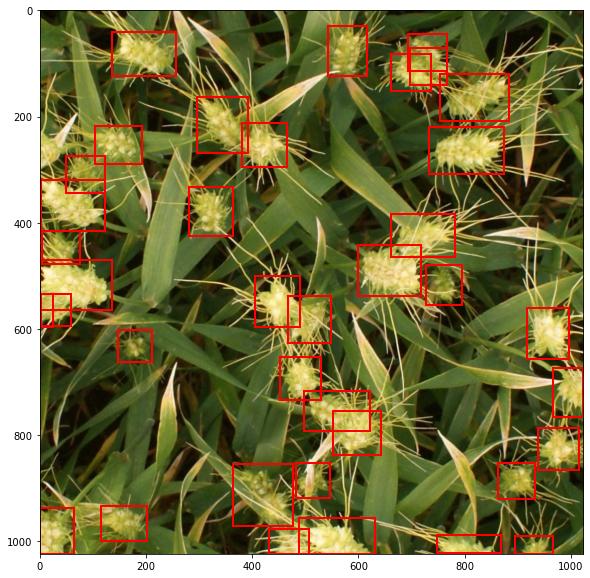

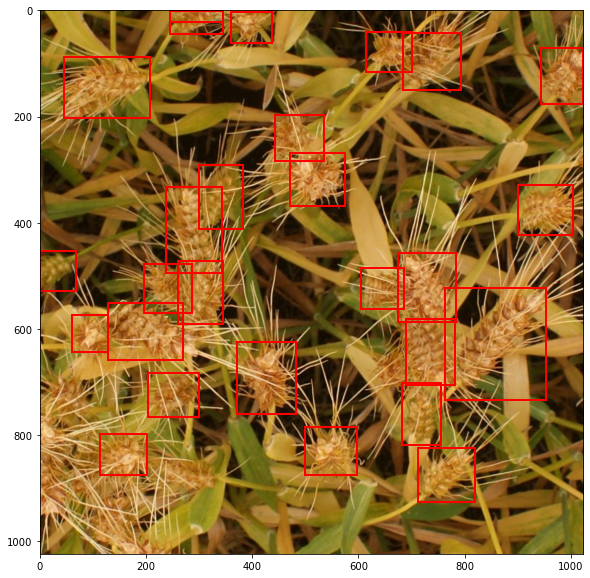

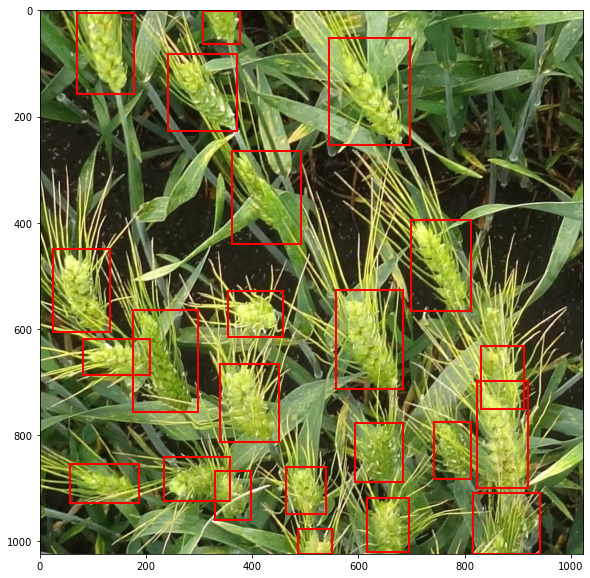

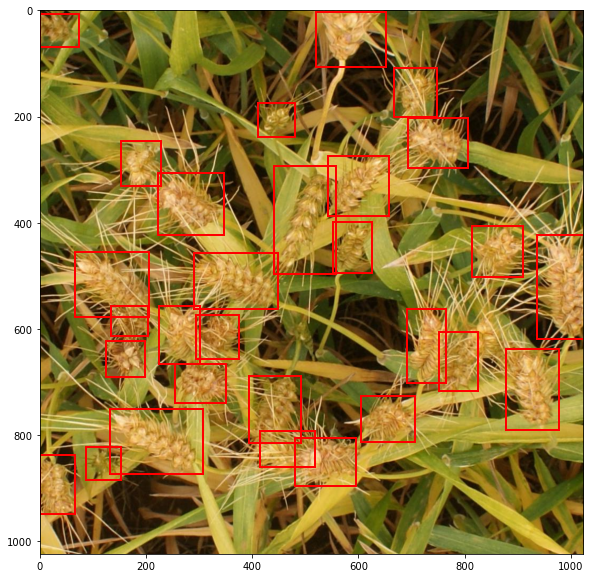

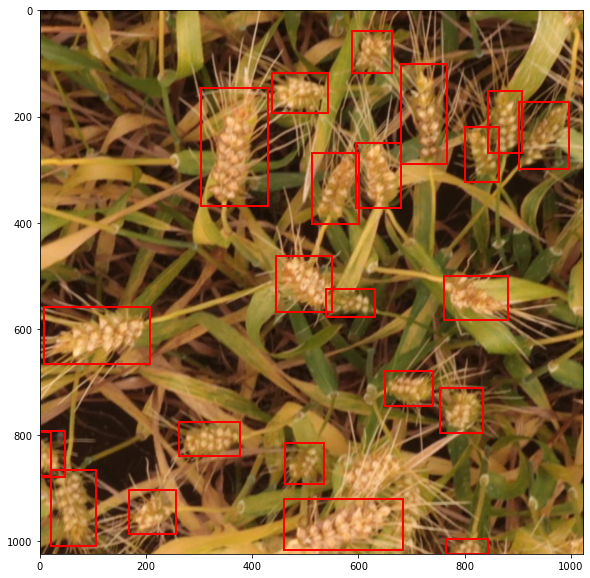

In [13]:
for img in os.listdir(TEST_DIR)[:5]:
    image = cv2.imread(os.path.join(TEST_DIR, img), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    preds = model([torch.from_numpy(np.transpose(image, (2, 0, 1))).to(device)])[0]
    
    pred_bboxes = preds['boxes'].cpu().detach().numpy()
    pred_scores = preds['scores'].cpu().detach().numpy()
    
    mask = pred_scores >= 0.4
    pred_scores = pred_scores[mask]
    pred_bboxes = pred_bboxes[mask]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    get_bbox(pred_bboxes, ax, color='red')
    ax.imshow(image)